<a href="https://colab.research.google.com/github/Mayankjh/Classifications_deeplearning/blob/master/ChestXray_Penumonia_(VGG16_%26_VGG19_Models_With_SGD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ls drive/'My Drive'/chest_xray1

test/  train/  val/


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("drive/My Drive/chest_xray1"))

from os import listdir, makedirs
from os.path import join, exists, expanduser

from keras.applications.inception_v3 import InceptionV3
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
from keras.utils.data_utils import Sequence
import sys
from PIL import *
sys.modules['Image'] = Image 
print(os.listdir("drive/My Drive/chest_xray1/train"))

['test', 'train', 'val', '.ipynb_checkpoints']


Using TensorFlow backend.


['NORMAL', 'PNEUMONIA']


In [0]:
img_width, img_height = 224,224
train_data = 'drive/My Drive/chest_xray1/train'
test_data = 'drive/My Drive/chest_xray1/test'
val_data = 'drive/My Drive/chest_xray1/val'

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_data,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')

Found 5226 images belonging to 2 classes.
Found 640 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [0]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)






553467904/553467096 [==============================] - 15s 0us/step








In [0]:

result = model.output
# result = GlobalAveragePooling2D()(result)
# add a fully-connected layer
# result1 = Dense(256, activation='relu')(result)
result = Dense(512, activation='relu')(result)
result = Dense(256, activation='relu')(result)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# and a fully connected output/classification layer
predictions = Dense(2, activation='sigmoid')(result)

In [0]:
inception_transfer = Model(inputs=model.input, outputs=predictions)


In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint(filepath='Penumonia_detector.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

inception_transfer.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
inception_transfer.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0 

In [0]:
history_pretrained = inception_transfer.fit_generator(
    train_generator,
    epochs=30, shuffle = True, verbose = 1, validation_data = test_generator, callbacks=[checkpoint, lr_reduce])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
164/164 [==============================] - 1932s 12s/step - loss: 0.6401 - acc: 0.7383 - val_loss: 0.6632 - val_acc: 0.6219
Epoch 2/30
164/164 [==============================] - 107s 651ms/step - loss: 0.5851 - acc: 0.7421 - val_loss: 0.6762 - val_acc: 0.6219
Epoch 3/30
164/164 [==============================] - 111s 677ms/step - loss: 0.5399 - acc: 0.7417 - val_loss: 0.6533 - val_acc: 0.6219
Epoch 4/30
164/164 [==============================] - 112s 682ms/step - loss: 0.4794 - acc: 0.7417 - val_loss: 0.5844 - val_acc: 0.6219

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
Epoch 5/30
164/164 [==============================] - 110s 671ms/step - loss: 0.4267 - acc: 0.7413 - val_loss: 0.5730 - val_acc: 0.6219
Epoch 6/30
164/164 [==============================] - 111s 678ms/step - loss: 0.3978 - acc: 0.7413 - val_loss: 0.5527 - val_acc: 0.6219

Epoch 0

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

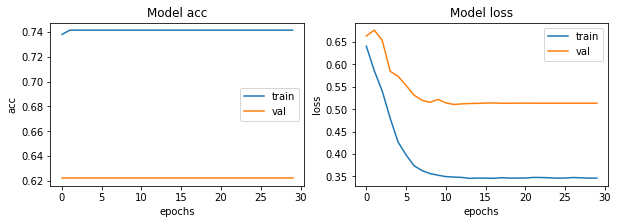

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()
for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_pretrained.history[met])
    ax[i].plot(history_pretrained.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
inception_transfer.summary()

574717952/574710816 [==============================] - 13s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________

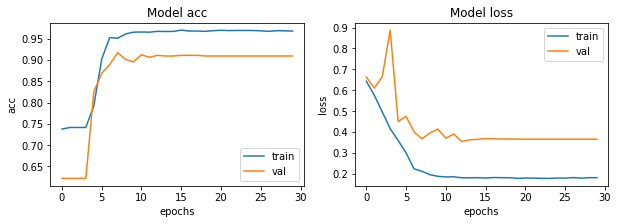

In [0]:
from keras.applications.vgg19 import VGG19
model = VGG19(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

result = model.output
result = Dense(512, activation='relu')(result)
result = Dense(256, activation='relu')(result)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
predictions = Dense(2, activation='sigmoid')(result)
inception_transfer = Model(inputs=model.input, outputs=predictions)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint(filepath='Penumonia_detector_checkpoint.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

inception_transfer.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
inception_transfer.summary()

history_pretrained = inception_transfer.fit_generator(
    train_generator,
    epochs=30, shuffle = True, verbose = 1, validation_data = test_generator, callbacks=[checkpoint, lr_reduce])
#graphs
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()
for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_pretrained.history[met])
    ax[i].plot(history_pretrained.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])